# Problem :
## Jaipur Rainfall Data
#### The problem is that Jaipur is one of the regions in India that has very limited amount of rainfall throught the year, So we will try to implement data analysis to predict what amount of rainfall will be recieved

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from os.path import join

In [2]:
# Location of Dataset
dataset = 'DataSet-Jaipur'
filename = 'JaipurRawData.csv'
filename = join(dataset, filename)

In [3]:
df = pd.read_csv(filename, index_col='date')
df.head()

,meantempm,meandewptm,meanpressurem,maxhumidity,minhumidity,maxtempm,mintempm,maxdewptm,mindewptm,maxpressurem,minpressurem,precipm
date,,,,,,,,,,,,
2016-05-01,34,-1,1005.63,24,4,43,26,9,-10,1009,999,0.0
2016-05-02,36,4,1005.46,21,6,43,29,10,-2,1008,1001,0.0
2016-05-03,35,6,1006.00,27,5,41,29,12,-2,1009,1000,0.0
2016-05-04,34,7,1005.65,29,6,41,27,13,0,1008,1001,0.0
2016-05-05,31,11,1007.94,61,13,38,24,16,6,1011,1003,5.0


In [4]:
print('Shape of Dataset: {}'.format(df.shape))
print('Shape of Each Row: {}'.format(df.iloc[0].shape))
print('')

Shape of Dataset: (679, 12)
Shape of Each Row: (12,)



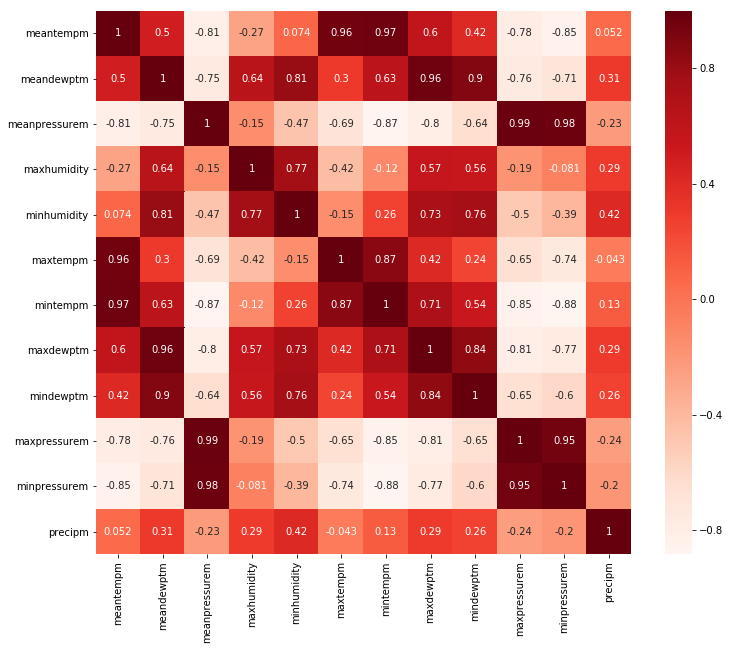

In [5]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

##### Pad Historic data for past 2 days with each row

In [6]:
def pad_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_meassurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_meassurements

In [7]:
df.columns

Index(['meantempm', 'meandewptm', 'meanpressurem', 'maxhumidity',
       'minhumidity', 'maxtempm', 'mintempm', 'maxdewptm', 'mindewptm',
       'maxpressurem', 'minpressurem', 'precipm'],
      dtype='object')

In [8]:
for column in df.columns:
#     if column != 'precipm':
    for n in range(1, 3):
        pad_nth_day_feature(df, column, n)

In [9]:
df.head()

,meantempm,meandewptm,meanpressurem,maxhumidity,minhumidity,maxtempm,mintempm,maxdewptm,mindewptm,maxpressurem,...,maxdewptm_1,maxdewptm_2,mindewptm_1,mindewptm_2,maxpressurem_1,maxpressurem_2,minpressurem_1,minpressurem_2,precipm_1,precipm_2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-01,34,-1,1005.63,24,4,43,26,9,-10,1009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-02,36,4,1005.46,21,6,43,29,10,-2,1008,...,9.0,NaN,-10.0,NaN,1009.0,NaN,999.0,NaN,0.0,NaN
2016-05-03,35,6,1006.00,27,5,41,29,12,-2,1009,...,10.0,9.0,-2.0,-10.0,1008.0,1009.0,1001.0,999.0,0.0,0.0
2016-05-04,34,7,1005.65,29,6,41,27,13,0,1008,...,12.0,10.0,-2.0,-2.0,1009.0,1008.0,1000.0,1001.0,0.0,0.0
2016-05-05,31,11,1007.94,61,13,38,24,16,6,1011,...,13.0,12.0,0.0,-2.0,1008.0,1009.0,1001.0,1000.0,0.0,0.0


In [10]:
# Changes in Shape
print('Shape of Dataset: {}'.format(df.shape))
print('Shape of Each Row: {}'.format(df.iloc[0].shape))

Shape of Dataset: (679, 36)
Shape of Each Row: (36,)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 679 entries, 2016-05-01 to 2018-03-11
Data columns (total 36 columns):
meantempm          679 non-null int64
meandewptm         679 non-null int64
meanpressurem      679 non-null float64
maxhumidity        679 non-null int64
minhumidity        679 non-null int64
maxtempm           679 non-null int64
mintempm           679 non-null int64
maxdewptm          679 non-null int64
mindewptm          679 non-null int64
maxpressurem       679 non-null int64
minpressurem       679 non-null int64
precipm            679 non-null float64
meantempm_1        678 non-null float64
meantempm_2        677 non-null float64
meandewptm_1       678 non-null float64
meandewptm_2       677 non-null float64
meanpressurem_1    678 non-null float64
meanpressurem_2    677 non-null float64
maxhumidity_1      678 non-null float64
maxhumidity_2      677 non-null float64
minhumidity_1      678 non-null float64
minhumidity_2      677 non-null float64
maxtempm_1         678 n

##### Doing Some Data Cleaning Operations

In [12]:
# Check if there is only one value in the column remove that feature
def check_uniqueness(dataframe):
    for column in dataframe.columns:
        if len(pd.Series.unique(dataframe[column])) == 1:
            dataframe.drop(column, inplace=True, axis=1)

            
    return dataframe

df = check_uniqueness(df)

In [13]:
# Drop Na Columns
df.dropna(inplace=True)

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantempm,677.0,26.066470,6.213891,10.00,20.0,28.00,30.00,38.00
meandewptm,677.0,11.982275,8.731514,-10.00,5.0,10.00,21.00,26.00
meanpressurem,677.0,1009.505081,6.478314,997.63,1003.7,1008.85,1015.52,1023.43
maxhumidity,677.0,67.397341,22.057420,15.00,50.0,66.00,88.00,100.00
minhumidity,677.0,22.794682,19.367531,4.00,9.0,15.00,33.00,89.00
maxtempm,677.0,32.536189,5.992397,18.00,28.0,33.00,37.00,46.00
mintempm,677.0,19.644018,6.830276,3.00,13.0,22.00,25.00,32.00
maxdewptm,677.0,16.166913,7.237327,0.00,10.0,15.00,23.00,29.00
mindewptm,677.0,7.478582,11.686926,-94.00,0.0,6.00,18.00,25.00
maxpressurem,677.0,1012.251108,6.527288,999.00,1006.0,1012.00,1018.00,1026.00


### Preparing Data

For Precipitation Prediction

In [15]:
y_data = df['precipm']
x_data = df.drop(['precipm'], axis=1)

In [16]:
print('Shape of X: {}'.format(x_data.shape))
print('Shape of Y: {}'.format(y_data.shape))

Shape of X: (677, 35)
Shape of Y: (677,)


#### Split Train and Test Data


In [17]:
# Split into Training and Test Set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [18]:
# Change them all to numpy array for faster computation
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
# Print Final Shapes of Sets
print('Training Set : X -> {}, Y -> {}'.format(x_train.shape, y_train.shape))
print('Testing Set: X -> {}, Y -> {}'.format(x_test.shape, y_test.shape))

Training Set : X -> (541, 35), Y -> (541,)
Testing Set: X -> (136, 35), Y -> (136,)


#### Now we have Training Set, Validation Set and Testing Set

##### 1. Applying Linear Regression

In [141]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [142]:
y_test_predicted = lin_reg.predict(x_test)

In [143]:
# Root Mean Square Error
lin_rmse = np.round(np.sqrt(mean_squared_error(y_test,y_test_predicted)), 5)
print('Root Mean Square Error: {}'.format(lin_rmse))

# R2 Score
lin_r2 = np.round(r2_score(y_test,y_test_predicted), 5)
print('R2 Score : {}'.format(lin_r2))


Root Mean Square Error: 3.68219
R2 Score : -0.00576


##### 2. Fitting Polynomial Regression

In [158]:
from sklearn.preprocessing import PolynomialFeatures

In [159]:
polynomial_history = []

In [160]:
for degree in range(2,5):

    polynomial_features= PolynomialFeatures(degree=degree)
    x_train_poly = polynomial_features.fit_transform(x_train)
    x_test_poly = polynomial_features.fit_transform(x_test)
    lin_reg = LinearRegression()
    lin_reg.fit(x_train_poly, y_train)
    y_test_poly_predicted = lin_reg.predict(x_test_poly)
    rmse = np.round(np.sqrt(mean_squared_error(y_test, y_test_poly_predicted)), 5)
    print('Root Mean Square Error: {}'.format(rmse))
    
    # R2 Score
    r2 = np.round(r2_score(y_test,y_test_poly_predicted), 5)
    print('R2 Score : {}'.format(r2))
    
    polynomial_history.append((degree, rmse))
    

Root Mean Square Error: 31.584
R2 Score : -55.41844
Root Mean Square Error: 21.62843
R2 Score : -25.45679
Root Mean Square Error: 20.18192
R2 Score : -22.03625


#### Plotting Linear Regression with Polynomial Regression RMSE

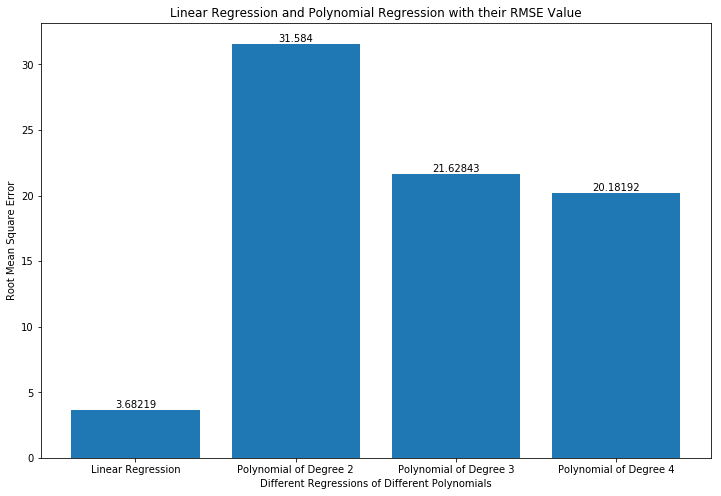

In [161]:
plt.figure(figsize=(12,8))
plt.title('Linear Regression and Polynomial Regression with their RMSE Value')
plt.xlabel('Different Regressions of Different Polynomials')
plt.ylabel('Root Mean Square Error')
bar_heights = plt.bar(['Linear Regression'] + ['Polynomial of Degree {}'.format(x[0]) for x in polynomial_history], [lin_rmse] + [x[1] for x in polynomial_history])
for rect in bar_heights:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{}'.format(height), ha='center', va='bottom')
plt.show()

#### Therefore, In case of Regression the Minimum Value of Root Mean Square Error is seen in ***Linear Regression***

##### 2. Recursive Feature Selection on Linear Regression
We will use Wrapper Method of Recursive Feature Selection

In [194]:
lin_reg_fs = LinearRegression()
rfe = RFE(lin_reg_fs, 10)
fit = rfe.fit(x_data, y_data)

In [195]:
print("Num Features: {}".format(fit.n_features_))
print("Selected Features: {}".format(fit.support_))
print("Feature Ranking: {}".format(fit.ranking_))

Num Features: 10
Selected Features: [False  True  True False  True  True False False False False False False
  True False False  True  True False False False False  True False False
  True False False False False  True False False False False False]
Feature Ranking: [26  1  1  9  1  1 11 24 19 15 17  5  1  4 12  1  1  8 23 25 13  1 21  7
  1  6 16 20 22  1 10  3  2 14 18]


In [196]:
x_feature_selected_data = rfe.transform(x_data)
x_feature_selected_data.shape

(677, 10)

Now Splitting the data to train and test set

In [197]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(541, 35) (541,) (136, 35) (136,)


In [198]:
lin_reg_fs.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [199]:
y_predicted = lin_reg_fs.predict(x_test)

In [200]:
lin_rmse_fs = np.round(np.sqrt(mean_squared_error(y_test,y_predicted)), 5)
print('Root Mean Square Error: {}'.format(lin_rmse_fs))

lin_r2 = np.round(r2_score(y_test,y_predicted), 5)
print('R2 Score : {}'.format(lin_r2))


Root Mean Square Error: 3.43921
R2 Score : 0.3935


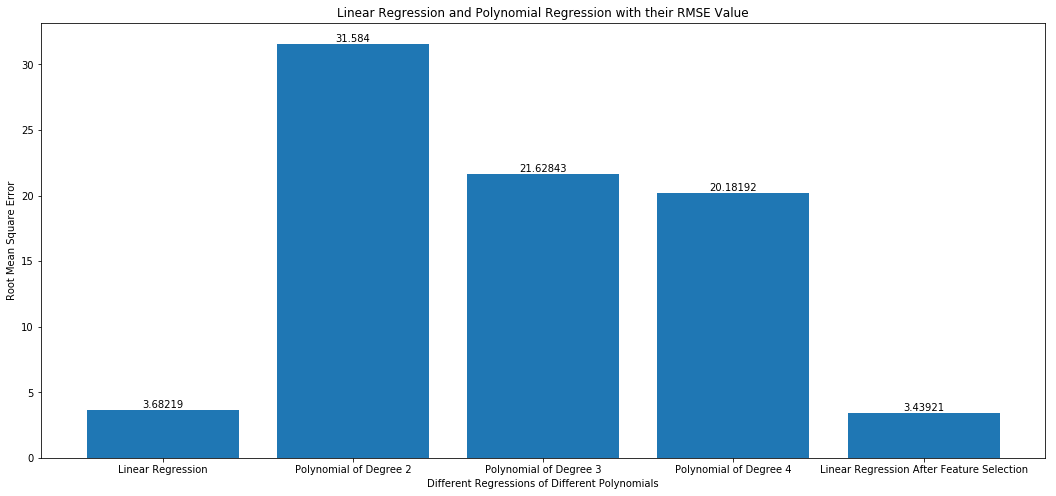

In [201]:
plt.figure(figsize=(18,8))
plt.title('Linear Regression and Polynomial Regression with their RMSE Value')
plt.xlabel('Different Regressions of Different Polynomials')
plt.ylabel('Root Mean Square Error')
bar_heights = plt.bar(['Linear Regression'] + ['Polynomial of Degree {}'.format(x[0]) for x in polynomial_history] + ['Linear Regression After Feature Selection'], [lin_rmse] + [x[1] for x in polynomial_history] + [lin_rmse_fs] )
for rect in bar_heights:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{}'.format(height), ha='center', va='bottom')
plt.show()

## Feature Selection Reduced the Mean Square Error thus with Feature Selection we got a better fit

# Lets Analysis The response of Neural Netoworks in This Scenario